# Inference of hierarchical tanh Gaussian model parameters

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}, \sigma _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(\tanh y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, \sigma ^2 _{\mathrm{pop}})
$$

# Synthesise data

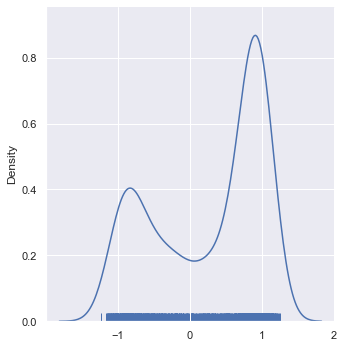

In [37]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [0.7, 2, 0.1] # [0.7, 1, 0.1]  # pop mean log, pop std. log, noise log
means = np.tanh(np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids))
data = means + np.random.normal(loc=0, scale=true_parameters[2], size=n_ids)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact hierarchical log-likelihood
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood
4. Rank-matching Gaussian KDE filter log-likelihood

In [38]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids = len(observations)
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        mu = parameters[:self._n_ids]
        pop_mean, pop_sigma = parameters[self._n_ids:self._n_ids+2]
        sigma = 0.1
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(pop_sigma)
            - (mu - pop_mean)**2 / pop_sigma**2 / 2)

        # Compute contributions from individual log-likelihoods
        means = np.tanh(mu)
        score += np.sum(
            - np.log(2 * np.pi) / 2 - np.log(sigma)
            - (means - self._observations)**2 / sigma**2 / 2)

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        mu = parameters[:self._n_ids]
        pop_mean, pop_sigma = parameters[self._n_ids:self._n_ids+2]
        sigma = 1
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=mu)

        # Compute contributions from individual log-likelihoods
        means = np.tanh(mu)
        score += np.sum(
            - np.log(2 * np.pi) / 2 - np.log(sigma)
            - (means - self._observations)**2 / sigma**2 / 2)

        # Compute sensitivities
        sensitivities = np.zeros(self.n_parameters())
        sensitivities[:-2] = \
            -(means - self._observations) * (1 - means**2) / sigma**2

        # Add population sensitivities
        sensitivities += pop_sens

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 2

    def get_parameter_names(self):
        return ['Mu'] * self._n_ids + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None] * 2


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = observations
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 0.1

        # Compute measurements
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute log-likelihood
        score = np.sum(
            scipy.stats.norm(loc=pop_mu_hat, scale=pop_sigma_hat).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 0.1

        # Compute measurements
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma * (1 - mean_samples**2) / self._n_samples
        dpop_mu_hat_depsilon = sigma / self._n_samples
        dpop_mu_hat_dpop_mu = np.mean(1 - mean_samples**2)
        dpop_mu_hat_dpop_sigma = np.mean((1 - mean_samples**2) * eta)
        dpop_sigma_hat_deta = \
            pop_sigma * (1 - mean_samples**2) * \
            (measurements - pop_mu_hat) / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / \
            (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = np.sum(
             (1 - mean_samples**2 - np.mean(1 - mean_samples**2))
            * (measurements - pop_mu_hat) / (self._n_samples - 1)
            / pop_sigma_hat)
        dpop_sigma_hat_dpop_sigma = np.sum(
            ((1 - mean_samples**2) * eta
            - np.mean((1 - mean_samples**2) * eta))
            * (measurements - pop_mu_hat) / (self._n_samples - 1)
            / pop_sigma_hat)

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma]), shape=(n_obs, self._n_samples + 3))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] \
            + sens[self._n_samples+3] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples] \
            + sens[self._n_samples+3] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[self._n_samples+1] \
            + sens[self._n_samples+3] * dpop_sigma_hat_dpop_mu
        sensitivities[2*self._n_samples+1] = \
            sens[self._n_samples+2] \
            + sens[self._n_samples+3] * dpop_sigma_hat_dpop_sigma

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 2

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mu'] + [
            'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [
            None] * 2


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 0.1

        # Compute measurements
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 0.1

        # Compute measurements
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * (1 - mean_samples**2)[np.newaxis, :], axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax, axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * (1 - mean_samples**2)[np.newaxis, :])
        sensitivities[2*self._n_samples+1] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * (1 - mean_samples**2)[np.newaxis, :]
                * eta[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 2

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [
            None] * 2


class RankMatchingGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu, pop_sigma = parameters[self._n_samples:self._n_samples+2]
        sigma = 0.1

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mean_samples[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = parameters[:self._n_samples]
        pop_mu, pop_sigma = parameters[self._n_samples:self._n_samples+2]
        sigma = 0.1

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = np.tanh(pop_mu + eta * pop_sigma)

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mean_samples[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var
            * (1 - mean_samples**2)[:, np.newaxis]
            * (mean_samples[:, np.newaxis] - self._observations), axis=1)
        sensitivities[self._n_samples] = \
            -  np.sum(1 / kernel_var * (1 - mean_samples**2)[:, np.newaxis]
            * (mean_samples[:, np.newaxis] - self._observations))
        sensitivities[self._n_samples+1] = \
            -  np.sum(eta[:, np.newaxis] / kernel_var
            * (1 - mean_samples**2)[:, np.newaxis]
            * (mean_samples[:, np.newaxis] - self._observations))

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 2

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None] * 2

## Inference

### 1. Exact hierarchical inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.1      2        0:00.1
1     8      0.25     1        0:00.1
2     11     0.126    2        0:00.2
3     266    0.499    128      0:03.7
20    5106   0.769    269      1:12.5
40    10673  0.733    266      2:20.6
60    14279  0.776    172      3:08.8
80    18188  0.729    187      3:58.6
100   21195  0.726724 144      4:38.0
120   21676  0.748    23       4:44.3
140   22298  0.731    30       4:53.0
160   22799  0.702    24       4:59.8
180   23435  0.755    31       5:08.4
200   23927  0.747    24       5:15.1
220   24371  0.754    22       5:21.1
240   24783  0.755    20       5:27.2
260   25569  0.703    38       5:37.3
280   27244  0.775    80       5:59.7
300   28460  0.741    58       6:15.5
320   29440  0.748    47       6:28.3
340   30467  0.738    49       6:42.0
360   31567  0.757    53       6:56.0
380   32497  0.752    45       7:08.4
400   33455  0.744

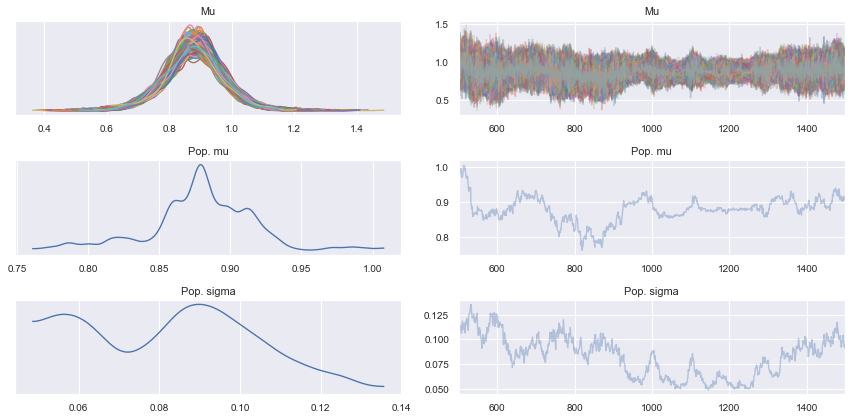

In [9]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = np.arctanh(means)
controller._initial_params[0, 0, -2:] = np.array([1.3, 1])
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

### 1. Gaussian filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.0
20    2301   0.766146 128      0:01.6
40    5198   0.74212  138      0:03.4
60    7594   0.75     115      0:04.9
80    11713  0.76     197      0:08.1
100   14422  0.756    129      0:09.9
120   16440  0.680559 97       0:11.3
140   20272  0.78     183      0:14.2
160   22822  0.729    122      0:16.0
180   26194  0.761    161      0:18.2
200   28494  0.735    110      0:19.7
220   31002  0.763    120      0:21.3
240   33766  0.772    132      0:23.1
260   36680  0.718    139      0:25.6
280   40233  0.754    170      0:27.9
300   43477  0.75     155      0:29.6
320   46821  0.751    160      0:31.4
340   49420  0.77     124      0:32.8
360   51448  0.769    97       0:33.9
380   54312  0.753    137      0:35.4
400   56276  0.735

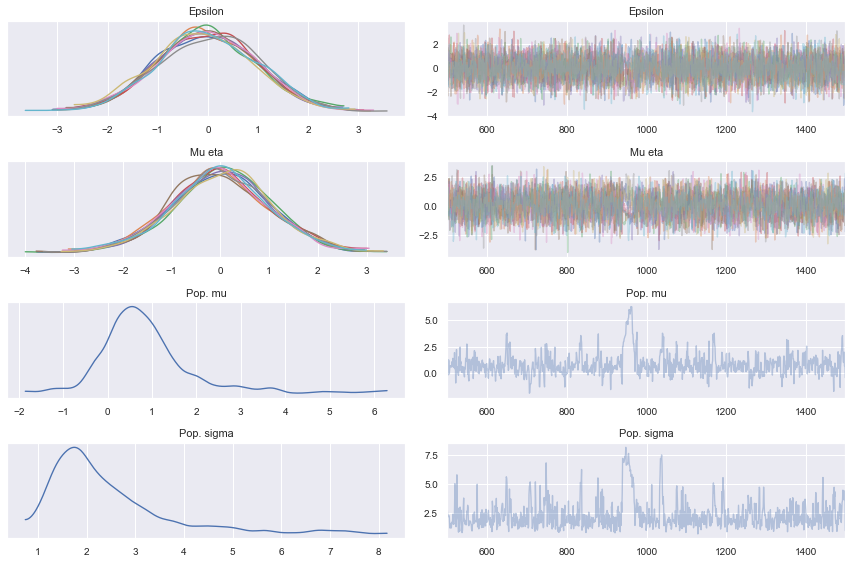

In [39]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.25     1        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     10     0.25     1        0:00.0
20    1364   0.751    76       0:02.4
40    3609   0.731    107      0:06.1
60    5829   0.745    106      0:09.3
80    7761   0.752    92       0:12.1
100   9201   0.715    69       0:14.2
120   10095  0.735    43       0:15.5
140   11003  0.758    44       0:16.7
160   12060  0.703    51       0:18.0
180   12728  0.765    32       0:18.8
200   13492  0.744323 37       0:19.8
220   14112  0.756    30       0:20.6
240   14812  0.77     34       0:21.4
260   15472  0.727    32       0:22.2
280   16380  0.755643 44       0:23.4
300   17240  0.748561 41       0:24.4
320   17956  0.744    35       0:25.3
340   18560  0.769    29       0:26.0
360   19100  0.768    26       0:26.7
380   19720  0.751    30       0:27.5
400   20212  0.742

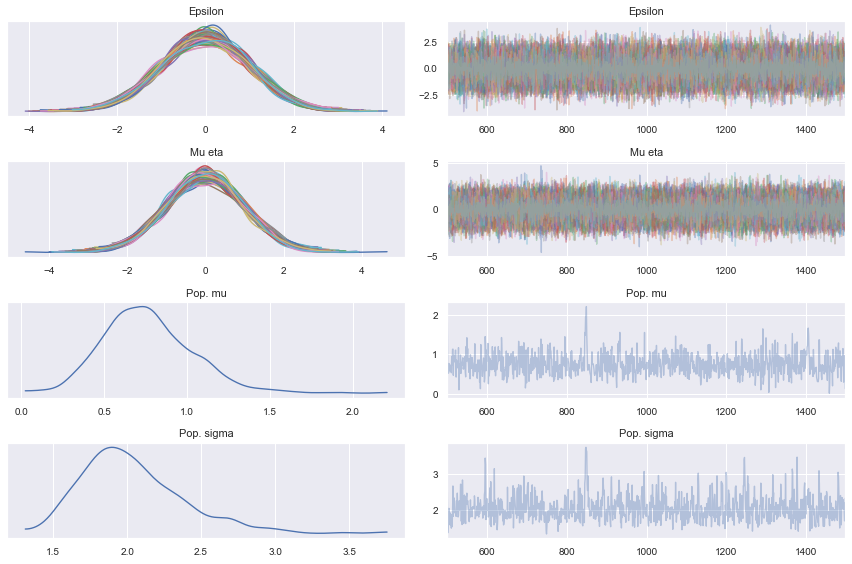

In [40]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     258    0.5      128      0:02.8
1     259    0.25     1        0:02.8
2     290    0.015625 16       0:03.1
3     545    0.5      128      0:05.7
20    11536  0.725    611      1:45.5
40    24060  0.772    597      3:46.3
60    29672  0.755    268      4:43.4
80    32244  0.788    123      5:09.7
100   33714  0.784    70       5:24.7
120   34165  0.709116 22       5:29.3
140   34689  0.763    25       5:34.7
160   35203  0.694    25       5:40.1
180   35735  0.756    26       5:45.2
200   36219  0.761    24       5:49.8
220   36711  0.756    24       5:54.4
240   37155  0.754    22       5:58.6
260   37515  0.726    18       6:02.0
280   38127  0.736871 30       6:07.7
300   38595  0.770332 23       6:12.2
320   39007  0.756    20       6:16.1
340   39419  0.767    20       6:20.0
360   39903  0.735    24       6:25.7
380   40363  0.775    22       6:30.0
400   40727  0.74 

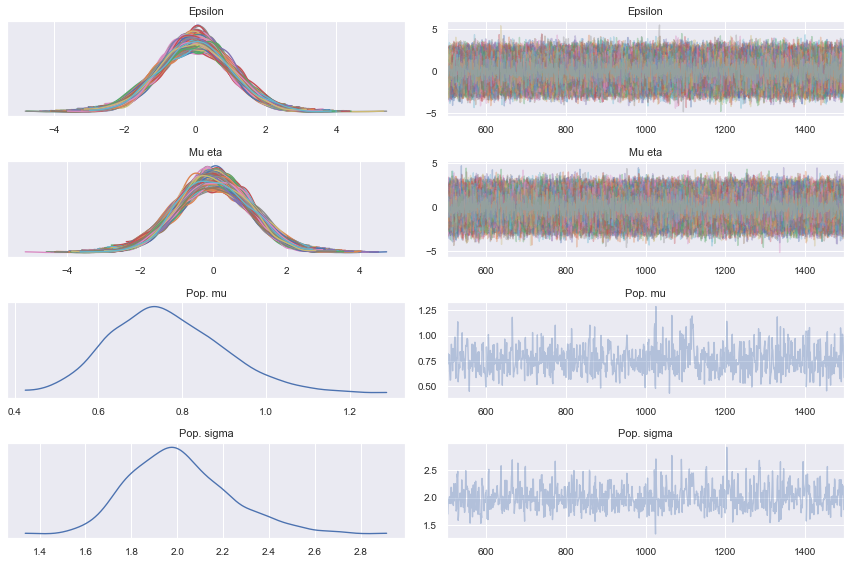

In [41]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 2. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     8      0.25     1        0:00.0
1     9      0.25     1        0:00.0
2     10     0.25     1        0:00.0
3     11     0.25     1        0:00.0
20    333    0.703    18       0:00.4
40    13865  0.699421 645      0:14.1
60    21475  0.797    363      0:21.2
80    25978  0.745    215      0:25.3
100   30785  0.732    229      0:29.8
120   32724  0.715    93       0:31.6
140   35130  0.772    115      0:33.8
160   36162  0.706    49       0:34.8
180   38895  0.767    131      0:37.4
200   41071  0.726    104      0:39.4
220   42691  0.772    78       0:41.0
240   44157  0.739    70       0:42.4
260   45745  0.701    76       0:43.9
280   48633  0.781    138      0:47.2
300   50465  0.763    88       0:49.1
320   51813  0.761519 65       0:50.5
340   53240  0.755    68       0:51.8
360   54516  0.744    61       0:53.6
380   55920  0.754    67       0:55.0
400   57302  0.746

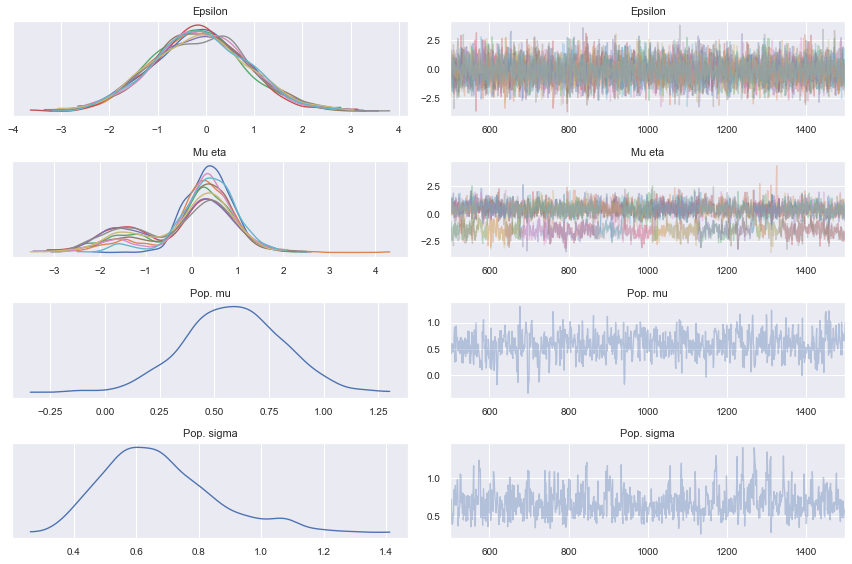

In [27]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.2      2        0:00.0
1     9      0.167    1        0:00.1
2     12     0.25     2        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


3     72     0.15     30       0:00.4
20    4574   0.77768  251      0:20.5
40    8641   0.759    194      0:39.4
60    12458  0.751    182      0:56.2
80    16655  0.744    200      1:13.0
100   19839  0.767    152      1:25.7
120   20763  0.718    44       1:29.5
140   21767  0.751    48       1:33.9
160   22826  0.713    51       1:38.3
180   23750  0.762    44       1:42.0
200   24466  0.754    35       1:44.8
220   25166  0.764    34       1:47.6
240   25946  0.739    38       1:50.8
260   26646  0.732    34       1:54.0
280   27666  0.743    49       1:58.3
300   28494  0.776    40       2:01.6
320   29178  0.759617 33       2:04.3
340   29942  0.748    37       2:07.4
360   30498  0.747    27       2:09.6
380   31118  0.777    30       2:12.1
400   31914  0.759    38       2:15.3
420   32598  0.76     33       2:18.1
440   33266  0.748    32       2:20.8
460   34198  0.72     45       2:24.6
480   35138  0.7502   45       2:28.4
500   35854  0.773    35       2:32.3
520   36474 

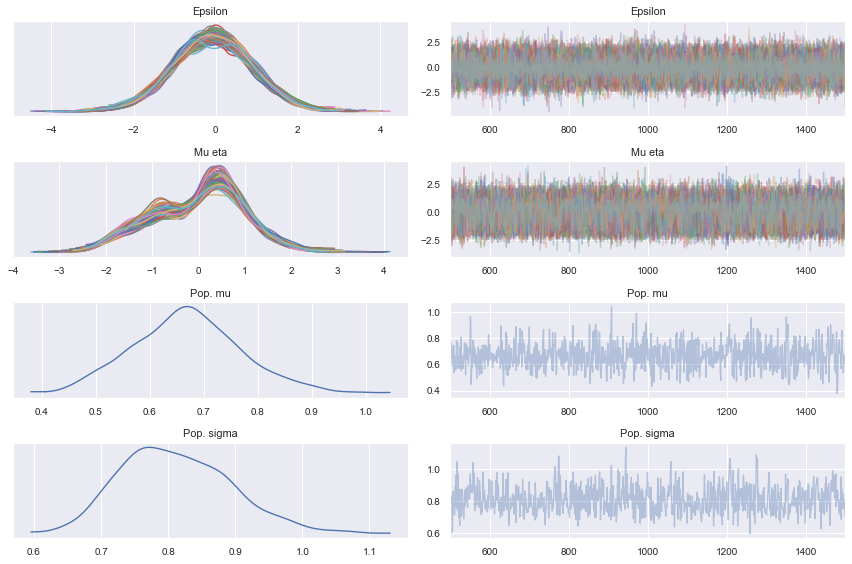

In [32]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     514    0.367    256      0:24.6
1     517    0.125    2        0:24.8
2     644    0.498884 64       0:31.5
3     707    0.354    32       0:35.1
20    2810   0.747379 117      2:14.6
40    5030   0.778399 106      3:50.7
60    7506   0.762456 118      5:42.8
80    9342   0.759    88       7:04.8
100   11214  0.751    89       8:29.0
120   12610  0.724    67       9:32.8
140   13774  0.764    56      10:27.7
160   15143  0.695    65      11:33.1
180   16755  0.767767 77      12:50.8
200   18079  0.757    64      13:51.4
220   19083  0.749    48      14:36.3
240   20151  0.755    51      15:27.0
260   21211  0.735    51      16:18.6
280   22375  0.739    56      17:12.7
300   23731  0.76613  65      18:15.2
320   24735  0.736    48      19:00.4
340   25835  0.791    53      19:48.4
360   26775  0.752    45      20:29.5
380   27779  0.748    48      21:14.5
400   28847  0.751

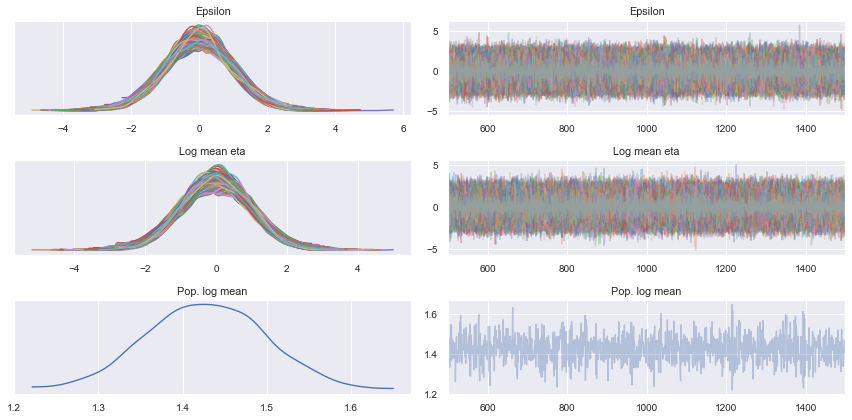

In [44]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [45]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_gaussian_kde_filter_1000.nc')

In [42]:
gaussian_kde_filter_1000_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_gaussian_kde_filter_1000.nc')

## Comparison to analytic posterior

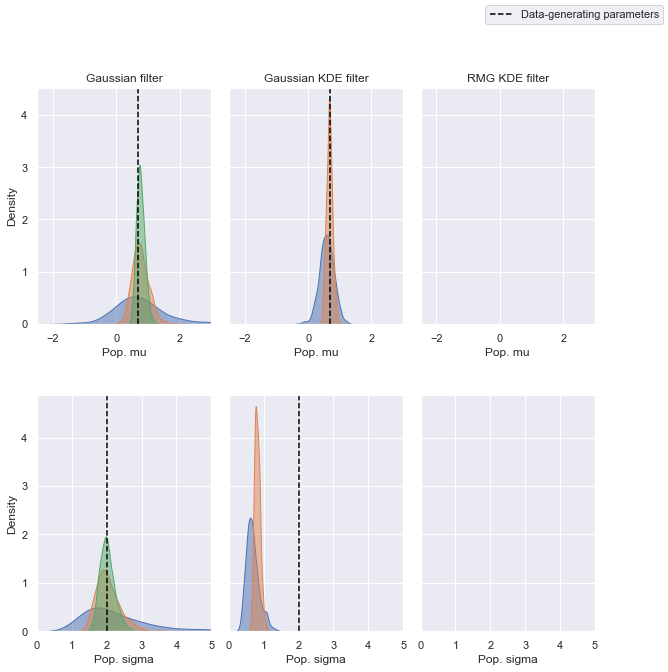

In [45]:
# Create figure
fig, axes = plt.subplots(
    2, 3, figsize=(10, 10), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0, 0].set_xlim([-2.5, 3])
axes[1, 0].set_xlim([0, 5])
axes[0, 0].set_xlabel('Pop. mu')
axes[0, 1].set_xlabel('Pop. mu')
axes[0, 2].set_xlabel('Pop. mu')
axes[1, 0].set_xlabel('Pop. sigma')
axes[1, 1].set_xlabel('Pop. sigma')
axes[1, 2].set_xlabel('Pop. sigma')
axes[0, 0].set_title('Gaussian filter')
axes[0, 1].set_title('Gaussian KDE filter')
axes[0, 2].set_title('RMG KDE filter')
colors = sns.color_palette()

# Plot Gaussian filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

# Plot Gaussian KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[0], legend=False)

# # Plot RMG KDE filter posteriors
# warmup = 500
# thinning = 1
# mu_samples = rmg_kde_filter_10_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
# sigma_samples = rmg_kde_filter_10_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
#     palette=colors[0], legend=False)
# sns.kdeplot(
#     x=sigma_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
#     palette=colors[0], legend=False)

# warmup = 1000
# thinning = 10
# mu_samples = rmg_kde_filter_100_posterior_samples.sel(
#     draw=slice(warmup, 10000, thinning))['Pop. mu'].values[0]
# sigma_samples = rmg_kde_filter_100_posterior_samples.sel(
#     draw=slice(warmup, 10000, thinning))['Pop. sigma'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
#     palette=colors[0], legend=False)
# sns.kdeplot(
#     x=sigma_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
#     palette=colors[0], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = rmg_kde_filter_500_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
# sigma_samples = rmg_kde_filter_500_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
#     palette=colors[0], legend=False)
# sns.kdeplot(
#     x=sigma_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
#     palette=colors[0], legend=False)

# Overlay true parameters
axes[0, 0].axvline(
    x=true_parameters[0], color='black', linestyle='--',
    label='Data-generating parameters')
axes[1, 0].axvline(
    x=true_parameters[1], color='black', linestyle='--')
axes[0, 1].axvline(
    x=true_parameters[0], color='black', linestyle='--')
axes[1, 1].axvline(
    x=true_parameters[1], color='black', linestyle='--')

fig.legend()
# plt.tight_layout()
plt.show()

## Gaussian approximation of data

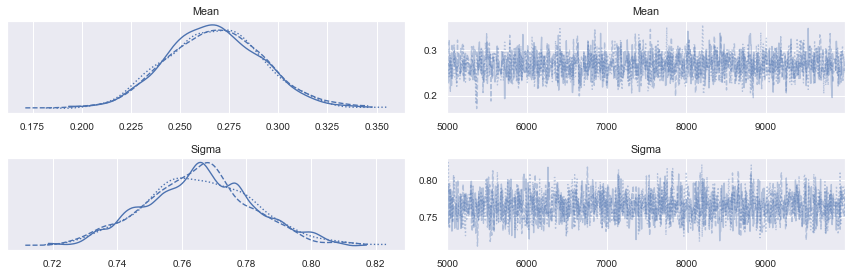

In [46]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations.flatten()

    def __call__(self, parameters):
        # Compute population contribution
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Sigma']

    def get_id(self):
        return [None, None]


log_likelihood = GaussianLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10000),
    pints.UniformLogPrior(0, 1000)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(3)
controller.set_parallel_evaluation(True)
controller.set_transform(pints.LogTransformation(log_posterior.n_parameters()))
n_iterations = 10000
gaussian_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 5000
thinning_ratio = 5
az.plot_trace(
    gaussian_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

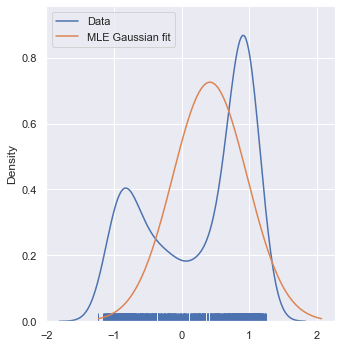

In [47]:
# Sample from Gaussian approximation
mean = 0.42
sigma = 0.55
mus = np.linspace(mean - 3 * sigma, mean + 3 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color=colors[1], label='MLE Gaussian fit')

plt.legend()
plt.show()